#  RMSE test with noise & w/o noise
- Author: Yong Lee (yongli.cv@gmail.com)
- Date: Sep 1st, 2021

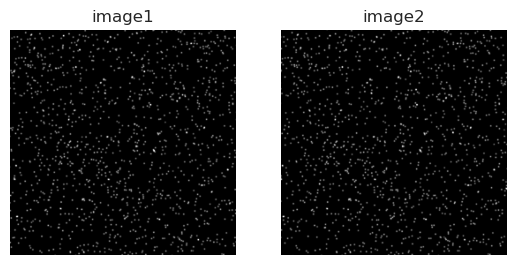

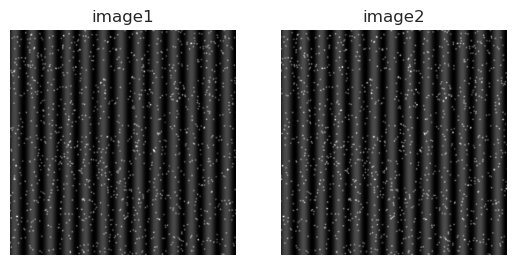

In [1]:
# Display the noise-free images and noisy images
import numpy as np
import cv2
from piv import PIV
from data import gen_image_pair
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import seaborn as sns
from utils import tool
from tqdm import tqdm
import os

sns.set_style()
sns.set()
plt.style.use('seaborn-dark-palette')


def show_img_pair(img1, img2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(img1,cmap='gray')
    plt.axis('off')
    plt.title("image1")
    plt.subplot(1,2,2)
    plt.imshow(img2,cmap='gray')
    plt.axis('off')
    plt.title("image2")
    
    
# config for PIG (particle image generator)
cfg_pig = tool.AttrDict
cfg_pig.img_sz = (256,256)
cfg_pig.ppp = 0.02
cfg_pig.dp = 2.2  # [0.6,2.2, 4.0]
cfg_pig.d_std = 0.01
cfg_pig.i_std = 0.1
cfg_pig.miss_ratio = 0.1
cfg_pig.displacement = 5.25


image1, image2= gen_image_pair(cfg_pig)
show_img_pair(np.transpose(image1), np.transpose(image2))

x, y = np.meshgrid(np.arange(image1.shape[1]),np.arange(image1.shape[0]))
noise = 50*(np.sin(2*np.pi*y/20)+1)
cv2.imwrite("xx1.png", image1)
image1, image2 = image1+noise, image2+noise
show_img_pair(np.transpose(image1), np.transpose(image2))
cv2.imwrite("xx2.png", image1)

plt.show()

In [2]:
# Run Monte-Carlo Simulation to evaluate the performance
RUNS = 100
disp_list = np.arange(0.0,10.01,0.1)  # displacement 
method_list  =['pc', 'spof', 'cfcc', 'scc', 'rpc', 'sbcc_b1', 'sbcc_b2', 'sbcc_b3', 'sbcc']


def test(dp=2.2, noise_flag=False):
    # config for piv 
    cfg_piv = tool.AttrDict()
    cfg_piv.win_sz = [32,32]
    cfg_piv.runs = 1
    cfg_piv.step_sz =[16,16]
    cfg_piv.subpixel='gaussian' # 'gaussian' # 'centroid' # 'parabolic'

    # config for PIG (particle image generator)
    cfg_pig = tool.AttrDict
    cfg_pig.img_sz = (256,256)
    cfg_pig.ppp = 0.02
    # cfg_pig.dp = 0.1  # [0.6,2.2, 4.0]
    cfg_pig.d_std = 0.01
    cfg_pig.i_std = 0.1
    cfg_pig.miss_ratio = 0.1
    cfg_pig.dp = dp

    
    result_rmse = np.zeros((len(disp_list),len(method_list), RUNS))
    result_bias = np.zeros((len(disp_list),len(method_list), RUNS))
    result_outlier = np.zeros((len(disp_list),len(method_list), RUNS))
    for run in range(RUNS):
        print(f"\tThe {run+1}/{RUNS} run...")
        for i, disp in tqdm(enumerate(disp_list)) :
            cfg_pig.displacement = disp 
            image1, image2= gen_image_pair(cfg_pig)
            if noise_flag:
                x, y = np.meshgrid(np.arange(image1.shape[1]),np.arange(image1.shape[0]))
                noise = 50*(np.sin(2*np.pi*y/20)+1)
                image1, image2 = image1+noise, image2+noise

            for j, method in enumerate(method_list):
                cfg_piv.method = method
                piv = PIV(cfg_piv)
                u, v, r_map= piv.compute(image1, image2)

                v_res, u_res = np.abs(v-disp), np.abs(u)
                mask = (v_res>1) + (u_res>1) # masks
                v_res[mask]= 1.0
                u_res[mask]= 1.0

                rmse = np.nanmean(v_res**2)
                bias = np.nanmean(v-disp)
                outlier = np.sum(mask)/np.prod(mask.shape)
                result_rmse[i,j,run]=rmse
                result_bias[i,j,run]=bias
                result_outlier[i,j,run]=outlier
                info=f"disp:{disp:0.2f},method:{method:5s}, RMSE:{rmse:0.4f}, outlier:{outlier:5.0f}"
    return result_rmse, result_outlier

print("The full exp may take about 134(mins) with 100 runs ...\n ")
print("Start the standard test ...\n ")
rmse1, outlier1 = test()

print("Start the rmse test with noise background ...\n ")
rmse2, outlier2 = test(noise_flag=True)

The full exp may take about 134(mins) with 100 runs ...
 
Start the standard test ...
 
	The 1/100 run...


101it [00:38,  2.64it/s]


	The 2/100 run...


101it [00:38,  2.64it/s]


	The 3/100 run...


101it [00:38,  2.64it/s]


	The 4/100 run...


101it [00:38,  2.64it/s]


	The 5/100 run...


101it [00:38,  2.64it/s]


	The 6/100 run...


101it [00:38,  2.63it/s]


	The 7/100 run...


101it [00:38,  2.62it/s]


	The 8/100 run...


101it [00:38,  2.62it/s]


	The 9/100 run...


101it [00:38,  2.63it/s]


	The 10/100 run...


101it [00:38,  2.63it/s]


	The 11/100 run...


101it [00:38,  2.64it/s]


	The 12/100 run...


101it [00:38,  2.64it/s]


	The 13/100 run...


101it [00:38,  2.62it/s]


	The 14/100 run...


101it [00:38,  2.60it/s]


	The 15/100 run...


101it [00:38,  2.63it/s]


	The 16/100 run...


101it [00:38,  2.63it/s]


	The 17/100 run...


101it [00:38,  2.64it/s]


	The 18/100 run...


101it [00:38,  2.64it/s]


	The 19/100 run...


101it [00:38,  2.64it/s]


	The 20/100 run...


101it [00:38,  2.64it/s]


	The 21/100 run...


101it [00:38,  2.64it/s]


	The 22/100 run...


101it [00:38,  2.63it/s]


	The 23/100 run...


101it [00:38,  2.63it/s]


	The 24/100 run...


101it [00:38,  2.64it/s]


	The 25/100 run...


101it [00:38,  2.63it/s]


	The 26/100 run...


101it [00:38,  2.62it/s]


	The 27/100 run...


101it [00:38,  2.60it/s]


	The 28/100 run...


101it [00:38,  2.64it/s]


	The 29/100 run...


101it [00:38,  2.63it/s]


	The 30/100 run...


101it [00:38,  2.62it/s]


	The 31/100 run...


101it [00:38,  2.62it/s]


	The 32/100 run...


101it [00:38,  2.62it/s]


	The 33/100 run...


101it [00:38,  2.63it/s]


	The 34/100 run...


101it [00:38,  2.62it/s]


	The 35/100 run...


101it [00:38,  2.59it/s]


	The 36/100 run...


101it [00:38,  2.61it/s]


	The 37/100 run...


101it [00:38,  2.60it/s]


	The 38/100 run...


101it [00:38,  2.61it/s]


	The 39/100 run...


101it [00:40,  2.49it/s]


	The 40/100 run...


101it [00:39,  2.58it/s]


	The 41/100 run...


101it [00:38,  2.61it/s]


	The 42/100 run...


101it [00:39,  2.55it/s]


	The 43/100 run...


101it [00:39,  2.56it/s]


	The 44/100 run...


101it [00:39,  2.57it/s]


	The 45/100 run...


101it [00:39,  2.58it/s]


	The 46/100 run...


101it [00:39,  2.59it/s]


	The 47/100 run...


101it [00:39,  2.53it/s]


	The 48/100 run...


101it [00:39,  2.54it/s]


	The 49/100 run...


101it [00:39,  2.55it/s]


	The 50/100 run...


101it [00:38,  2.59it/s]


	The 51/100 run...


101it [00:38,  2.62it/s]


	The 52/100 run...


101it [00:38,  2.63it/s]


	The 53/100 run...


101it [00:38,  2.63it/s]


	The 54/100 run...


101it [00:38,  2.63it/s]


	The 55/100 run...


101it [00:38,  2.63it/s]


	The 56/100 run...


101it [00:39,  2.59it/s]


	The 57/100 run...


101it [00:38,  2.60it/s]


	The 58/100 run...


101it [00:39,  2.56it/s]


	The 59/100 run...


101it [00:39,  2.56it/s]


	The 60/100 run...


101it [00:38,  2.62it/s]


	The 61/100 run...


101it [00:38,  2.62it/s]


	The 62/100 run...


101it [00:38,  2.62it/s]


	The 63/100 run...


101it [00:38,  2.63it/s]


	The 64/100 run...


101it [00:38,  2.63it/s]


	The 65/100 run...


101it [00:38,  2.63it/s]


	The 66/100 run...


101it [00:38,  2.63it/s]


	The 67/100 run...


101it [00:38,  2.63it/s]


	The 68/100 run...


101it [00:38,  2.61it/s]


	The 69/100 run...


101it [00:39,  2.58it/s]


	The 70/100 run...


101it [00:38,  2.61it/s]


	The 71/100 run...


101it [00:38,  2.63it/s]


	The 72/100 run...


101it [00:38,  2.63it/s]


	The 73/100 run...


101it [00:38,  2.64it/s]


	The 74/100 run...


101it [00:38,  2.64it/s]


	The 75/100 run...


101it [00:38,  2.63it/s]


	The 76/100 run...


101it [00:38,  2.64it/s]


	The 77/100 run...


101it [00:38,  2.63it/s]


	The 78/100 run...


101it [00:38,  2.63it/s]


	The 79/100 run...


101it [00:38,  2.63it/s]


	The 80/100 run...


101it [00:38,  2.61it/s]


	The 81/100 run...


101it [00:38,  2.63it/s]


	The 82/100 run...


101it [00:38,  2.64it/s]


	The 83/100 run...


101it [00:38,  2.63it/s]


	The 84/100 run...


101it [00:38,  2.63it/s]


	The 85/100 run...


101it [00:39,  2.59it/s]


	The 86/100 run...


101it [00:38,  2.64it/s]


	The 87/100 run...


101it [00:38,  2.64it/s]


	The 88/100 run...


101it [00:38,  2.62it/s]


	The 89/100 run...


101it [00:38,  2.62it/s]


	The 90/100 run...


101it [00:38,  2.61it/s]


	The 91/100 run...


101it [00:38,  2.62it/s]


	The 92/100 run...


101it [00:38,  2.62it/s]


	The 93/100 run...


101it [00:38,  2.62it/s]


	The 94/100 run...


101it [00:38,  2.62it/s]


	The 95/100 run...


101it [00:38,  2.63it/s]


	The 96/100 run...


101it [00:38,  2.63it/s]


	The 97/100 run...


101it [00:38,  2.63it/s]


	The 98/100 run...


101it [00:38,  2.63it/s]


	The 99/100 run...


101it [00:38,  2.63it/s]


	The 100/100 run...


101it [00:38,  2.64it/s]


Start the rmse test with noise background ...
 
	The 1/100 run...


101it [00:38,  2.64it/s]


	The 2/100 run...


101it [00:38,  2.64it/s]


	The 3/100 run...


101it [00:38,  2.64it/s]


	The 4/100 run...


101it [00:38,  2.64it/s]


	The 5/100 run...


101it [00:38,  2.64it/s]


	The 6/100 run...


101it [00:38,  2.64it/s]


	The 7/100 run...


101it [00:38,  2.65it/s]


	The 8/100 run...


101it [00:38,  2.64it/s]


	The 9/100 run...


101it [00:38,  2.64it/s]


	The 10/100 run...


101it [00:38,  2.64it/s]


	The 11/100 run...


101it [00:38,  2.64it/s]


	The 12/100 run...


101it [00:38,  2.64it/s]


	The 13/100 run...


101it [00:38,  2.64it/s]


	The 14/100 run...


101it [00:38,  2.64it/s]


	The 15/100 run...


101it [00:38,  2.64it/s]


	The 16/100 run...


101it [00:38,  2.64it/s]


	The 17/100 run...


101it [00:38,  2.64it/s]


	The 18/100 run...


101it [00:38,  2.64it/s]


	The 19/100 run...


101it [00:38,  2.63it/s]


	The 20/100 run...


101it [00:38,  2.64it/s]


	The 21/100 run...


101it [00:38,  2.64it/s]


	The 22/100 run...


101it [00:39,  2.53it/s]


	The 23/100 run...


101it [00:40,  2.49it/s]


	The 24/100 run...


101it [00:40,  2.50it/s]


	The 25/100 run...


101it [00:40,  2.52it/s]


	The 26/100 run...


101it [00:39,  2.56it/s]


	The 27/100 run...


101it [00:38,  2.60it/s]


	The 28/100 run...


101it [00:38,  2.62it/s]


	The 29/100 run...


101it [00:38,  2.60it/s]


	The 30/100 run...


101it [00:38,  2.61it/s]


	The 31/100 run...


101it [00:39,  2.53it/s]


	The 32/100 run...


101it [00:39,  2.59it/s]


	The 33/100 run...


101it [00:38,  2.60it/s]


	The 34/100 run...


101it [00:38,  2.61it/s]


	The 35/100 run...


101it [00:38,  2.65it/s]


	The 36/100 run...


101it [00:38,  2.64it/s]


	The 37/100 run...


101it [00:38,  2.64it/s]


	The 38/100 run...


101it [00:38,  2.65it/s]


	The 39/100 run...


101it [00:38,  2.64it/s]


	The 40/100 run...


101it [00:38,  2.64it/s]


	The 41/100 run...


101it [00:38,  2.64it/s]


	The 42/100 run...


101it [00:38,  2.64it/s]


	The 43/100 run...


101it [00:38,  2.65it/s]


	The 44/100 run...


101it [00:38,  2.65it/s]


	The 45/100 run...


101it [00:38,  2.65it/s]


	The 46/100 run...


101it [00:38,  2.65it/s]


	The 47/100 run...


101it [00:38,  2.64it/s]


	The 48/100 run...


101it [00:38,  2.65it/s]


	The 49/100 run...


101it [00:38,  2.63it/s]


	The 50/100 run...


101it [00:38,  2.64it/s]


	The 51/100 run...


101it [00:38,  2.63it/s]


	The 52/100 run...


101it [00:38,  2.65it/s]


	The 53/100 run...


101it [00:38,  2.64it/s]


	The 54/100 run...


101it [00:38,  2.64it/s]


	The 55/100 run...


101it [00:38,  2.64it/s]


	The 56/100 run...


101it [00:38,  2.64it/s]


	The 57/100 run...


101it [00:38,  2.64it/s]


	The 58/100 run...


101it [00:38,  2.65it/s]


	The 59/100 run...


101it [00:38,  2.64it/s]


	The 60/100 run...


101it [00:38,  2.64it/s]


	The 61/100 run...


101it [00:38,  2.64it/s]


	The 62/100 run...


101it [00:38,  2.64it/s]


	The 63/100 run...


101it [00:38,  2.64it/s]


	The 64/100 run...


101it [00:38,  2.64it/s]


	The 65/100 run...


101it [00:38,  2.64it/s]


	The 66/100 run...


101it [00:38,  2.65it/s]


	The 67/100 run...


101it [00:38,  2.65it/s]


	The 68/100 run...


101it [00:38,  2.64it/s]


	The 69/100 run...


101it [00:38,  2.64it/s]


	The 70/100 run...


101it [00:38,  2.65it/s]


	The 71/100 run...


101it [00:38,  2.65it/s]


	The 72/100 run...


101it [00:38,  2.64it/s]


	The 73/100 run...


101it [00:38,  2.63it/s]


	The 74/100 run...


101it [00:38,  2.64it/s]


	The 75/100 run...


101it [00:38,  2.64it/s]


	The 76/100 run...


101it [00:38,  2.64it/s]


	The 77/100 run...


101it [00:38,  2.64it/s]


	The 78/100 run...


101it [00:38,  2.64it/s]


	The 79/100 run...


101it [00:38,  2.64it/s]


	The 80/100 run...


101it [00:38,  2.64it/s]


	The 81/100 run...


101it [00:38,  2.63it/s]


	The 82/100 run...


101it [00:38,  2.62it/s]


	The 83/100 run...


101it [00:38,  2.64it/s]


	The 84/100 run...


101it [00:38,  2.64it/s]


	The 85/100 run...


101it [00:38,  2.64it/s]


	The 86/100 run...


101it [00:38,  2.64it/s]


	The 87/100 run...


101it [00:38,  2.64it/s]


	The 88/100 run...


101it [00:38,  2.64it/s]


	The 89/100 run...


101it [00:38,  2.64it/s]


	The 90/100 run...


101it [00:38,  2.64it/s]


	The 91/100 run...


101it [00:38,  2.64it/s]


	The 92/100 run...


101it [00:38,  2.64it/s]


	The 93/100 run...


101it [00:38,  2.64it/s]


	The 94/100 run...


101it [00:38,  2.63it/s]


	The 95/100 run...


101it [00:38,  2.64it/s]


	The 96/100 run...


101it [00:38,  2.64it/s]


	The 97/100 run...


101it [00:38,  2.63it/s]


	The 98/100 run...


101it [00:39,  2.56it/s]


	The 99/100 run...


101it [00:38,  2.62it/s]


	The 100/100 run...


101it [00:38,  2.63it/s]


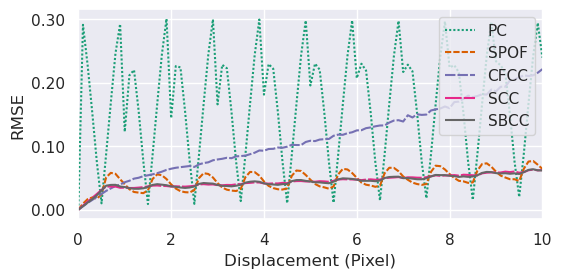

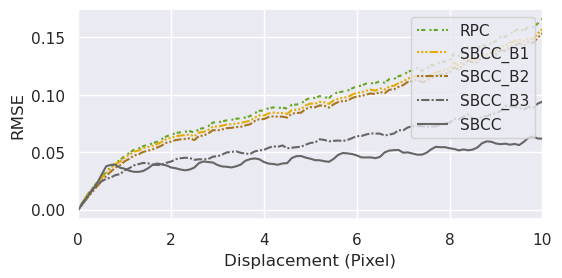

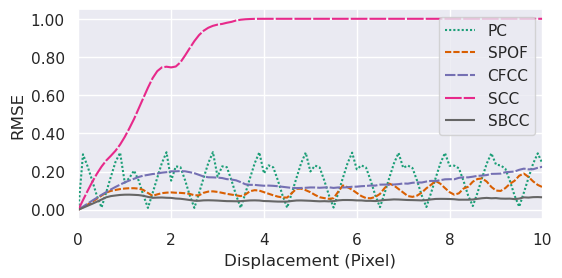

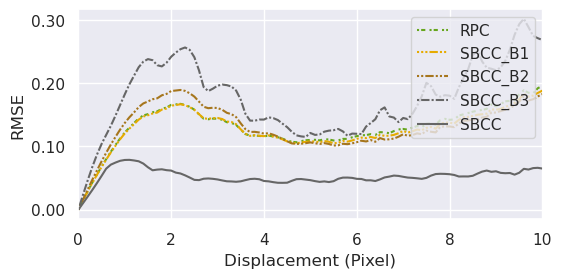

In [3]:
# method_list  =['pc', 'spof', 'cfcc', 'scc', 'rpc', 'sbcc_b1', 'sbcc_b2', 'sbcc_b3', 'sbcc']
line_styles = [(0,(1,1)), (0,(3,1)), (0,(5,1)), (0,(8,1)), (0,(1,1,2,2)), 
        (0,(1,1,1,1,1,1,4,1)), (0,(1,1,1,1,4,1)), (0,(1,1,4,1)), (0,())]
colors = cm.Dark2(np.linspace(0,1,9))
line_styles = dict(zip(method_list, line_styles))
colors = dict(zip(method_list, colors))


@ticker.FuncFormatter
def major_formatter(x, pos):
    return "%.2f" % x


def plot_results(result_rmse, methods=[], name=None):

    # plot the results
    fig = plt.figure(figsize=(6,3))
    # plt.axes(yscale='log')
    for method in methods:
        j = method_list.index(method)
        plt.plot(disp_list, np.sqrt(np.mean(result_rmse[:,j,:],axis=-1)), linestyle=line_styles[method],color=colors[method], label=method.upper())
    plt.xlim(np.min(disp_list)-0.01, np.max(disp_list)+0.01)
#     plt.ylim(-1e-3, 0.3)
    plt.ylabel("RMSE")
    plt.gca().yaxis.set_major_formatter(major_formatter)
    plt.xlabel("Displacement (Pixel)")
    plt.gcf().subplots_adjust(bottom=0.18)
    plt.legend(loc=1)
    plt.savefig(f'output/{name}.svg')
    plt.savefig(f'output/{name}.pdf')

plot_results(rmse1, methods=['pc', 'spof', 'cfcc', 'scc', 'sbcc'], name="Fig8a")
plot_results(rmse1, methods=['rpc', 'sbcc_b1', 'sbcc_b2', 'sbcc_b3', 'sbcc'], name="Fig8b")
plot_results(rmse2, methods=['pc', 'spof', 'cfcc', 'scc', 'sbcc'], name="Fig8c")
plot_results(rmse2, methods=['rpc', 'sbcc_b1', 'sbcc_b2', 'sbcc_b3', 'sbcc'], name="Fig8d")

plt.show()